In [1123]:
# load the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdg
from scipy.optimize import curve_fit



In [1124]:
# load the data
data_path = 'pi0s_from_120_GeV_pp.dat'
df = pd.read_csv(data_path, delim_whitespace=True, header=None)
df.columns = ['E', 'px', 'py', 'pz']
df

/tmp/ipykernel_68989/3531919497.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_path, delim_whitespace=True, header=None)


,E,px,py,pz
0,9.290869,-0.201131,-0.665001,9.263873
1,0.396785,-0.209107,0.078034,0.299004
2,4.349881,0.750735,-0.150422,4.279838
3,6.213590,-0.211418,-0.182143,6.205853
4,2.706387,-0.078871,-0.002744,2.701867
...,...,...,...,...
28114,0.520529,-0.029953,0.102010,0.491352
28115,5.077250,-0.380562,0.771184,5.002069
28116,10.084471,0.054645,0.366145,10.076769
28117,23.024465,0.182745,-0.146376,23.022879


In [1125]:
# Constants
m_pi0 = 0.1349766  # Neutral pion mass in GeV (natural units)
momenta_array = df[['E', 'px', 'py', 'pz']].to_numpy()


# Functions for Part 1

1. **`lorentz_product(A, B)`**:
   - **Purpose**: Computes the Lorentz product (or Minkowski inner product) of two four-vectors $A$ and $B$. This product is fundamental in the context of special relativity, as it remains invariant under Lorentz transformations, meaning it has the same value in all inertial frames.
   - **Inputs**:
     - `A`: A four-vector represented as a numpy array, where $A[0]$ is the time component (energy), and the subsequent elements are spatial components (momentum).
     - `B`: Another four-vector similar to `A`.
   - **Output**: The scalar Lorentz product, calculated as $A[0] \times B[0] - A_x \times B_x - A_y \times B_y - A_z \times B_z$.

2. **`invariant_mass(P)`**:
   - **Purpose**: Calculates the invariant mass of a single four-vector $P$. The invariant mass is a crucial concept in particle physics, representing the rest mass of the system.
   - **Input**:
     - `P`: A four-vector representing a particle's energy and momentum.
   - **Output**: The scalar invariant mass, computed using the formula $\sqrt{E^2 - |\mathbf{p}|^2}$, where $E$ is the energy and $|\mathbf{p}|$ the magnitude of the momentum vector.

3. **`system_mass(P1, P2)`**:
   - **Purpose**: Computes the invariant mass of a two-particle system given their individual four-vectors $P1$ and $P2$. This is used to understand interactions between particles.
   - **Inputs**:
     - `P1`, `P2`: Four-vectors representing the energy and momentum of two particles.
   - **Output**: The combined invariant mass of the system, using the Lorentz product of the total four-momentum of the system.

4. **`lorentz_transform(P, v)`**:
   - **Purpose**: Applies a Lorentz boost to a four-vector $P$ in the direction of a given velocity $v$. This transformation is essential for switching between different reference frames in particle physics.
   - **Inputs**:
     - `P`: A four-vector to which the Lorentz boost is applied.
     - `v`: A three-component vector representing the velocity direction and magnitude; it should be a subluminal velocity ($|\mathbf{v}| < 1$ when $c = 1$).
   - **Output**: The transformed four-vector after applying the boost. The boost ensures that the physics calculations account for relativistic effects due to the motion of reference frames. 


In [1126]:
def lorentz_product(A, B):
    """Computes the Lorentz product of two four-vectors."""
    return A[0] * B[0] - np.dot(A[1:], B[1:])

def invariant_mass(P):
    """Computes the invariant mass of a four-momentum vector P."""
    return np.sqrt(P[0]**2 - np.dot(P[1:], P[1:]))

def system_mass(P1, P2):
    """Computes the invariant mass of a system of two particles."""
    P_total = P1 + P2
    return np.sqrt(lorentz_product(P_total, P_total))

def lorentz_transform(P, v):
    """Applies a Lorentz boost to a four-vector P in the direction of velocity v."""
    v = np.array(v)
    v_mag = np.linalg.norm(v)
    if v_mag == 0:
        return P  # No boost needed
    
    beta = v_mag / 1  # Assume c=1
    gamma = 1 / np.sqrt(1 - beta**2)
    n = v / v_mag  # Normalize direction
    
    # Lorentz transformation matrix
    Lambda = np.array([
        [gamma, -gamma * beta * n[0], -gamma * beta * n[1], -gamma * beta * n[2]],
        [-gamma * beta * n[0], 1 + (gamma - 1) * n[0]**2, (gamma - 1) * n[0] * n[1], (gamma - 1) * n[0] * n[2]],
        [-gamma * beta * n[1], (gamma - 1) * n[1] * n[0], 1 + (gamma - 1) * n[1]**2, (gamma - 1) * n[1] * n[2]],
        [-gamma * beta * n[2], (gamma - 1) * n[2] * n[0], (gamma - 1) * n[2] * n[1], 1 + (gamma - 1) * n[2]**2]
    ])
    
    return np.dot(Lambda, P)

In [1127]:
def vectorized_lorentz_transform(p, v):
    """
    Perform a Lorentz boost on a batch of 4-vectors.
    
    Parameters
    ----------
    p : numpy.ndarray
        Array of 4-vectors in the rest frame, shape (N, 4), with columns [E, px, py, pz].
    v : numpy.ndarray
        Array of boost velocities, shape (N, 3). (Assuming units where c=1.)
    
    Returns
    -------
    numpy.ndarray
        Boosted 4-vectors in the lab frame, shape (N, 4).
    """
    # Compute beta^2 for each event (v²)
    beta2 = np.sum(v**2, axis=1, keepdims=True)  # shape: (N,1)
    # Calculate gamma factor for each event
    gamma = 1.0 / np.sqrt(1.0 - beta2)             # shape: (N,1)
    # Dot product between the spatial momentum and the boost velocity
    bp = np.sum(p[:, 1:] * v, axis=1, keepdims=True)  # shape: (N,1)
    
    # Calculate the factor (gamma - 1)/beta2 safely. Set to 0 when beta2 is nearly zero.
    with np.errstate(divide='ignore', invalid='ignore'):
        gamma2 = np.where(beta2 > 1e-12, (gamma - 1.0) / beta2, 0.0)  # shape: (N,1)
    
    # Boost the spatial components:
    # p[:, 1:] is (N,3) and v is (N,3); the operations are elementwise.
    spatial = p[:, 1:] + gamma2 * bp * v + gamma * p[:, :1] * v  # shape: (N,3)
    # Boost the energy component:
    energy = gamma * (p[:, :1] + bp)  # shape: (N,1)
    
    # Concatenate boosted energy and spatial parts along axis 1.
    boosted = np.hstack([energy, spatial])
    return boosted

def estimate_detection_fraction_vectorized(pi0_momenta, M, detector_size=1.0, distance=10.0):
    """
    Estimate the fraction of π⁰ decays for which at least one photon hits the detector.
    
    The detector is assumed to be a square centered at (x, y) = (0, 0) in a plane 
    located at z = distance. The size of the detector is detector_size (length of a side).
    
    Parameters
    ----------
    pi0_momenta : numpy.ndarray
        Lab frame 4-momenta of the π⁰ particles (shape: [N,4] with columns [E, px, py, pz]).
    M : float
        Mass of the π⁰ particle (in GeV/c²).
    detector_size : float, optional
        Size of the detector (side length), by default 1.0.
    distance : float, optional
        z-distance to the detector plane, by default 10.0.
    
    Returns
    -------
    float
        The estimated geometric efficiency (fraction of decays detected).
    """
    n_decays = len(pi0_momenta)
    
    # Generate random angles for isotropic decays in the pion rest frame.
    cos_theta = 2 * np.random.rand(n_decays) - 1
    theta = np.arccos(cos_theta)
    phi = 2 * np.pi * np.random.rand(n_decays)
    
    # In the rest frame of the π⁰, energy = |p| for a photon. Each photon gets half the mass.
    p_mag = M / 2.0

    # Photon 1 in the rest frame: 4-vector [E, px, py, pz]
    p1_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        p_mag * np.sin(theta) * np.cos(phi),
        p_mag * np.sin(theta) * np.sin(phi),
        p_mag * cos_theta
    ])
    
    # Photon 2 has exactly the opposite momentum.
    p2_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        -p_mag * np.sin(theta) * np.cos(phi),
        -p_mag * np.sin(theta) * np.sin(phi),
        -p_mag * cos_theta
    ])
    
    # Compute the boost velocity of the π⁰: v = p/E
    # pi0_momenta has columns [E, px, py, pz]
    v = pi0_momenta[:, 1:] / pi0_momenta[:, :1]  # shape: (N,3)
    
    # Boost both photons to the lab frame.
    p1_lab = vectorized_lorentz_transform(p1_rest, v)
    p2_lab = vectorized_lorentz_transform(p2_rest, v)
    
    def check_hits(p):
        """
        Check if the boosted photon (p) hits the detector.
        
        p is expected to be a numpy array of shape (N,4) for lab-frame 4-vectors.
        """
        # We are interested in the photon's z-component; if it is nearly zero or negative (moving backward), it won't hit.
        pz = p[:, 3]
        nonzero = np.abs(pz) > 1e-8
        # For photons moving toward the detector (i.e. pz > 0), compute the parametric distance t such that z = distance.
        # For non-moving or backward-moving photons, set t = infinity.
        t = np.where((pz > 0) & nonzero, distance / pz, np.inf)
        # The photon hits at positions (x_hit, y_hit)
        x_hit = p[:, 1] * t
        y_hit = p[:, 2] * t
        # Check if (x_hit, y_hit) fall within half the detector size.
        hit = (np.abs(x_hit) <= detector_size / 2.0) & (np.abs(y_hit) <= detector_size / 2.0)
        # Only count if the photon is moving forward.
        hit = hit & (pz > 0)
        return hit
    
    hits1 = check_hits(p1_lab)
    hits2 = check_hits(p2_lab)
    
    # An event is detected if at least one of the two photons hits the detector.
    detected = hits1 | hits2
    fraction_detected = np.mean(detected)
    return fraction_detected

if __name__ == '__main__':
    # Define the π⁰ mass (in GeV/c²)
    M_pi0 = 0.1349768
    n_events = 100000  # Number of decays to simulate
    
    # Generate random lab frame π⁰ momenta.
    # We'll sample the spatial momentum components from a normal distribution.
    lab_momenta_spatial = np.random.normal(0, 1, (n_events, 3))
    # Compute the energy using E = sqrt(p^2 + m^2)
    energies = np.sqrt(np.sum(lab_momenta_spatial**2, axis=1) + M_pi0**2)
    # Construct the π⁰ momenta array with columns [E, px, py, pz]
    pi0_momenta = np.column_stack([energies, lab_momenta_spatial])
    
    # Estimate the geometric efficiency:
    fraction = estimate_detection_fraction_vectorized(pi0_momenta, M_pi0,
                                                      detector_size=1.0,
                                                      distance=10.0)
    print(f"Geometric efficiency: {fraction:.6f}")
    print(f"Expected number of detected events: {fraction * n_events:.0f}")
    

Geometric efficiency: 0.001580
Expected number of detected events: 158


Professors Data is in `momenta_array`

In [1128]:
def vectorized_lorentz_transform(p, v):
    """
    Perform a Lorentz boost on a batch of 4-vectors.
    
    Parameters
    ----------
    p : numpy.ndarray
        Array of 4-vectors in the rest frame, shape (N, 4), with columns [E, px, py, pz].
    v : numpy.ndarray
        Array of boost velocities, shape (N, 3). (Assuming units where c=1.)
    
    Returns
    -------
    numpy.ndarray
        Boosted 4-vectors in the lab frame, shape (N, 4).
    """
    # Compute beta^2 for each event (v²)
    beta2 = np.sum(v**2, axis=1, keepdims=True)  # shape: (N,1)
    # Calculate gamma factor for each event
    gamma = 1.0 / np.sqrt(1.0 - beta2)             # shape: (N,1)
    # Dot product between the spatial momentum and the boost velocity
    bp = np.sum(p[:, 1:] * v, axis=1, keepdims=True)  # shape: (N,1)
    
    # Calculate the factor (gamma - 1)/beta2 safely. Set to 0 when beta2 is nearly zero.
    with np.errstate(divide='ignore', invalid='ignore'):
        gamma2 = np.where(beta2 > 1e-12, (gamma - 1.0) / beta2, 0.0)  # shape: (N,1)
    
    # Boost the spatial components:
    # p[:, 1:] is (N,3) and v is (N,3); the operations are elementwise.
    spatial = p[:, 1:] + gamma2 * bp * v + gamma * p[:, :1] * v  # shape: (N,3)
    # Boost the energy component:
    energy = gamma * (p[:, :1] + bp)  # shape: (N,1)
    
    # Concatenate boosted energy and spatial parts along axis 1.
    boosted = np.hstack([energy, spatial])
    return boosted

def estimate_detection_fraction_vectorized(pi0_momenta, M, detector_size=1.0, distance=10.0):
    """
    Estimate the fraction of π⁰ decays for which at least one photon hits the detector.
    
    The detector is assumed to be a square centered at (x, y) = (0, 0) in a plane 
    located at z = distance. The size of the detector is detector_size (length of a side).
    
    Parameters
    ----------
    pi0_momenta : numpy.ndarray
        Lab frame 4-momenta of the π⁰ particles (shape: [N,4] with columns [E, px, py, pz]).
    M : float
        Mass of the π⁰ particle (in GeV/c²).
    detector_size : float, optional
        Size of the detector (side length), by default 1.0.
    distance : float, optional
        z-distance to the detector plane, by default 10.0.
    
    Returns
    -------
    float
        The estimated geometric efficiency (fraction of decays detected).
    """
    n_decays = len(pi0_momenta)
    
    # Generate random angles for isotropic decays in the pion rest frame.
    cos_theta = 2 * np.random.rand(n_decays) - 1
    theta = np.arccos(cos_theta)
    phi = 2 * np.pi * np.random.rand(n_decays)
    
    # In the rest frame of the π⁰, energy = |p| for a photon. Each photon gets half the mass.
    p_mag = M / 2.0

    # Photon 1 in the rest frame: 4-vector [E, px, py, pz]
    p1_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        p_mag * np.sin(theta) * np.cos(phi),
        p_mag * np.sin(theta) * np.sin(phi),
        p_mag * cos_theta
    ])
    
    # Photon 2 has exactly the opposite momentum.
    p2_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        -p_mag * np.sin(theta) * np.cos(phi),
        -p_mag * np.sin(theta) * np.sin(phi),
        -p_mag * cos_theta
    ])
    
    # Compute the boost velocity of the π⁰: v = p/E
    # pi0_momenta has columns [E, px, py, pz]
    v = pi0_momenta[:, 1:] / pi0_momenta[:, :1]  # shape: (N,3)
    
    # Boost both photons to the lab frame.
    p1_lab = vectorized_lorentz_transform(p1_rest, v)
    p2_lab = vectorized_lorentz_transform(p2_rest, v)
    
    def check_hits(p):
        """
        Check if the boosted photon (p) hits the detector.
        
        p is expected to be a numpy array of shape (N,4) for lab-frame 4-vectors.
        """
        # We are interested in the photon's z-component; if it is nearly zero or negative (moving backward), it won't hit.
        pz = p[:, 3]
        nonzero = np.abs(pz) > 1e-8
        # For photons moving toward the detector (i.e. pz > 0), compute the parametric distance t such that z = distance.
        # For non-moving or backward-moving photons, set t = infinity.
        t = np.where((pz > 0) & nonzero, distance / pz, np.inf)
        # The photon hits at positions (x_hit, y_hit)
        x_hit = p[:, 1] * t
        y_hit = p[:, 2] * t
        # Check if (x_hit, y_hit) fall within half the detector size.
        hit = (np.abs(x_hit) <= detector_size / 2.0) & (np.abs(y_hit) <= detector_size / 2.0)
        # Only count if the photon is moving forward.
        hit = hit & (pz > 0)
        return hit
    
    hits1 = check_hits(p1_lab)
    hits2 = check_hits(p2_lab)
    
    # An event is detected if at least one of the two photons hits the detector.
    detected = hits1 | hits2
    fraction_detected = np.mean(detected)
    return fraction_detected

if __name__ == '__main__':
    # Define the π⁰ mass (in GeV/c²)
    M_pi0 = 0.1349768
    n_events = 100000  # Number of decays to simulate
    
    # Generate random lab frame π⁰ momenta.
    # We'll sample the spatial momentum components from a normal distribution.
    lab_momenta_spatial = np.random.normal(0, 1, (n_events, 3))
    # Compute the energy using E = sqrt(p^2 + m^2)
    energies = np.sqrt(np.sum(lab_momenta_spatial**2, axis=1) + M_pi0**2)
    # Construct the π⁰ momenta array with columns [E, px, py, pz]
    pi0_momenta = np.column_stack([energies, lab_momenta_spatial])
    
    # Estimate the geometric efficiency:
    fraction = estimate_detection_fraction_vectorized(momenta_array, M_pi0,
                                                      detector_size=1.0,
                                                      distance=10.0)
    print(f"Geometric efficiency: {fraction:.6f}")
    print(f"Expected number of detected events: {fraction * n_events:.0f}")

Geometric efficiency: 0.367545
Expected number of detected events: 36755


# Different Detector Sizes and Distances
Try 10m x 10m, 0.1m x 0.1m, and maybe different ranges for the distance to the detector.


In [1129]:
results = []
configurations = [
    {"detector_size": 1.0, "distance": 10.0},
    {"detector_size": 10.0, "distance": 1.0},
    {"detector_size": 10.0, "distance": 10.0},
    {"detector_size": 10.0, "distance": 100.0},
    {"detector_size": 0.1, "distance": 1.0},
    {"detector_size": 0.1, "distance": 10.0},
    {"detector_size": 0.1, "distance": 100.0},
]

for config in configurations:
    detector_size = config["detector_size"]
    distance = config["distance"]
    fraction = estimate_detection_fraction_vectorized(momenta_array, M_pi0,
                                                        detector_size=detector_size,
                                                        distance=distance)
    results.append({
        "detector_size": f"{detector_size:.1f}m x {detector_size:.1f}m",
        "distance": f"{distance:.1f}m",
        "efficiency": f"{fraction:.12f}"
    })

# Display results in a nice table
print("| Detector Size      | Distance | Geometric Efficiency |")
print("|----------------------|----------|----------------------|")
for result in results:
    print(f"| {result['detector_size']:<20} | {result['distance']:<8} | {result['efficiency']:<20} |")

| Detector Size      | Distance | Geometric Efficiency |
|----------------------|----------|----------------------|
| 1.0m x 1.0m          | 10.0m    | 0.369038728262       |
| 10.0m x 10.0m        | 1.0m     | 0.991891603542       |
| 10.0m x 10.0m        | 10.0m    | 0.912799174935       |
| 10.0m x 10.0m        | 100.0m   | 0.369429922828       |
| 0.1m x 0.1m          | 1.0m     | 0.367971833991       |
| 0.1m x 0.1m          | 10.0m    | 0.021480137985       |
| 0.1m x 0.1m          | 100.0m   | 0.000142252569       |


In [1130]:
results = []
configurations = [
    {"detector_size": 1.0, "distance": 10.0},
    {"detector_size": 10.0, "distance": 1.0},
    {"detector_size": 10.0, "distance": 10.0},
    {"detector_size": 10.0, "distance": 100.0},
    {"detector_size": 0.1, "distance": 1.0},
    {"detector_size": 0.1, "distance": 10.0},
    {"detector_size": 0.1, "distance": 100.0},
]

for config in configurations:
    detector_size = config["detector_size"]
    distance = config["distance"]
    fraction = estimate_detection_fraction_vectorized(pi0_momenta, M_pi0,
                                                        detector_size=detector_size,
                                                        distance=distance)
    results.append({
        "detector_size": f"{detector_size:.1f}m x {detector_size:.1f}m",
        "distance": f"{distance:.1f}m",
        "efficiency": f"{fraction:.12f}"
    })

# Display results in a nice table
print("| Detector Size      | Distance | Geometric Efficiency |")
print("|----------------------|----------|----------------------|")
for result in results:
    print(f"| {result['detector_size']:<20} | {result['distance']:<8} | {result['efficiency']:<20} |")

| Detector Size      | Distance | Geometric Efficiency |
|----------------------|----------|----------------------|
| 1.0m x 1.0m          | 10.0m    | 0.001690000000       |
| 10.0m x 10.0m        | 1.0m     | 0.458810000000       |
| 10.0m x 10.0m        | 10.0m    | 0.085960000000       |
| 10.0m x 10.0m        | 100.0m   | 0.001470000000       |
| 0.1m x 0.1m          | 1.0m     | 0.001680000000       |
| 0.1m x 0.1m          | 10.0m    | 0.000040000000       |
| 0.1m x 0.1m          | 100.0m   | 0.000000000000       |


## Two body decay of particle with mass $M$ at rest
Description of the `two_body_decay_rest` function:

**Purpose**:
- This function simulates the decay of a particle with mass $ M $ into two daughter particles with masses $ m_1 $ and $ m_2 $ in the rest frame of the decaying particle.
- It generates random four-momenta for the daughter particles, ensuring isotropy and conservation of energy and momentum.

**Inputs**:
- `M`: Scalar value representing the mass of the decaying particle.
- `m1`: Scalar value representing the mass of the first daughter particle.
- `m2`: Scalar value representing the mass of the second daughter particle.

**Output**:
- Two numpy arrays (`p1` and `p2`) representing the four-momenta of the daughter particles. Each four-vector includes: energy, $ p_x $, $ p_y $, and $ p_z $.

**Key Steps**:
1. **Energy Calculation**:
   - Calculates the energy $ E_1 $ and $ E_2 $ of the daughter particles using the formula for energy conservation. This ensures the decay products maintain the correct energy balance for the given masses.

2. **Momentum Magnitude**:
   - Computes the magnitude of the momentum $ p_{mag} $ using the relation derived from energy-momentum conservation. This assumes that the total system's momentum in the rest frame is zero.

3. **Random Direction Generation**:
   - Generates isotropic directions for the decay products by sampling angles:
     - `theta`: A polar angle sampled uniformly in $ \cos(\theta) $, ensuring isotropy.
     - `phi`: An azimuthal angle sampled uniformly from 0 to $ 2\pi $.

4. **Momentum Vector Construction**:
   - Constructs the momentum vectors for the first daughter particle `p1` using spherical coordinates to ensure the isotropic distribution.
   - The momentum vector for the second daughter particle `p2` is simply the opposite of `p1`, ensuring the conservation of total momentum (i.e., net momentum is zero as required in the rest frame).

5. **Returns**:
   - The function returns the four-momenta of the two daughter particles, correctly modeling a two-body decay process where the decaying particle was initially at rest.

This function is a fundamental component for accurately simulating decay processes, essential in high-energy physics and particle experiments where such kinematic analyses are common.

In [1131]:
def two_body_decay_rest(M, m1, m2):
    """Generates two random four-momenta for a two-body decay in the rest frame of the decaying particle."""
    E1 = (M**2 + m1**2 - m2**2) / (2 * M)
    E2 = (M**2 + m2**2 - m1**2) / (2 * M)
    p_mag = np.sqrt(E1**2 - m1**2)  # Magnitude of the momentum
    
    # Generate a random isotropic direction
    theta = np.arccos(2 * np.random.rand() - 1)  # Uniform in cos(theta)
    phi = 2 * np.pi * np.random.rand()  # Uniform in phi
    
    p1 = np.array([E1, p_mag * np.sin(theta) * np.cos(phi), p_mag * np.sin(theta) * np.sin(phi), p_mag * np.cos(theta)])
    p2 = np.array([E2, -p1[1], -p1[2], -p1[3]])  # Opposite direction
    
    return p1, p2

In [1132]:
def two_body_decay(M, m1, m2, v):
    """Generates two random four-momenta for a two-body decay in the rest frame of the decaying particle,
    then boosts them to the lab frame where the decaying particle moves with velocity v."""
    E1 = (M**2 + m1**2 - m2**2) / (2 * M)
    E2 = (M**2 + m2**2 - m1**2) / (2 * M)
    p_mag = np.sqrt(E1**2 - m1**2)  # Magnitude of the momentum
    
    # Generate a random isotropic direction
    theta = np.arccos(2 * np.random.rand() - 1)  # Uniform in cos(theta)
    phi = 2 * np.pi * np.random.rand()  # Uniform in phi
    
    p1 = np.array([E1, p_mag * np.sin(theta) * np.cos(phi), p_mag * np.sin(theta) * np.sin(phi), p_mag * np.cos(theta)])
    p2 = np.array([E2, -p1[1], -p1[2], -p1[3]])  # Opposite direction
    
    # Boost to the lab frame
    p1_lab = lorentz_transform(p1, v)
    p2_lab = lorentz_transform(p2, v)
    
    return p1_lab, p2_lab



##  Photons that hit detector and estimating detection fraction
 Description of the `photon_hits_detector` and `estimate_detection_fraction` functions:

### `photon_hits_detector(p_photon)`

**Purpose**:
- This function checks whether a photon, represented by its four-momentum, hits a detector positioned perpendicularly along the beam line at a specific location.

**Inputs**:
- `p_photon`: A four-momentum vector of the photon, where `p_photon[3]` is the component of the momentum along the z-axis.

**Output**:
- A boolean value: `True` if the photon hits the detector and `False` otherwise.

**Key Steps**:
1. **Direction Check**:
   - The function first checks if the photon is moving toward the detector by ensuring the z-component of momentum (`p_photon[3]`) is positive. If not, the photon is moving away, and `False` is immediately returned.

2. **Intersection Calculation**:
   - If the photon is moving toward the detector, it calculates where the photon's path will intersect with the plane at `z = 10m`.
   - `scale` is a factor used to determine the intersection point of the photon's path with the `z = 10m` plane by scaling its x and y components accordingly.

3. **Position Check**:
   - The function verifies whether the intersection point lies within the bounds of the detector's 1m x 1m face (centered at the origin in the x-y plane).
   - Returns `True` if the intersection point is within these bounds, otherwise `False`.

### `estimate_detection_fraction(pi0_momenta, M, m1, m2)`

**Purpose**:
- Estimates the fraction of neutral pion ($\pi^0$) decays that result in at least one photon reaching a specified detector.

**Inputs**:
- `pi0_momenta`: An array of four-momentum vectors for $\pi^0$ particles.
- `M`: The mass of the decaying particle ($\pi^0$).
- `m1`, `m2`: Masses of the decay products (for photon decay, both are 0).

**Output**:
- A float representing the fraction of decays where at least one photon hits the detector.

**Key Steps**:
1. **Initialization**:
   - Initializes a counter `count_detected` to track the number of decay events where at least one photon hits the detector.

2. **Iterate Over Decays**:
   - For each $\pi^0$ in `pi0_momenta`, perform a two-body decay to simulate the production of two photons using the `two_body_decay` function.

3. **Boost to Lab Frame**:
   - Transform the photon momenta from the rest frame to the lab frame using the `lorentz_transform` function, taking into account the original pion's momentum.

4. **Photon Check**:
   - Each pair of photons is checked against the detector using the `photon_hits_detector` function. If either or both photons hit the detector, increment `count_detected`.

5. **Calculate Fraction**:
   - Return the fraction of decay events where at least one photon is detected by dividing `count_detected` by the total number of decay events (`total_decays`).

This setup elegantly combines relativistic physics with geometric detection criteria to simulate a realistic scenario in high-energy physics experiments.

In [1133]:
def lorentz_product(A, B):
    """Computes the Lorentz product of two four-vectors."""
    return A[0] * B[0] - np.dot(A[1:], B[1:])

def invariant_mass(P):
    """Computes the invariant mass of a four-momentum vector P."""
    return np.sqrt(abs(lorentz_product(P, P)))

def system_mass(P1, P2):
    """Computes the invariant mass of a system of two particles."""
    P_total = P1 + P2
    return np.sqrt(abs(lorentz_product(P_total, P_total)))
# this function is a bit bugged due to numerical issues
def lorentz_transform_bugged(P, v):
    """Applies a Lorentz boost to a four-vector P in the direction of velocity v."""
    v = np.array(v)
    v_mag = np.linalg.norm(v)
    if v_mag == 0:
        return P  # No boost needed
    
    beta = v_mag / 1  # Assume c=1
    gamma = 1 / np.sqrt(1 - beta**2)
    n = v / v_mag  # Normalize direction
    
    # Lorentz transformation matrix
    Lambda = np.array([
        [gamma, -gamma * beta * n[0], -gamma * beta * n[1], -gamma * beta * n[2]],
        [-gamma * beta * n[0], 1 + (gamma - 1) * n[0]**2, (gamma - 1) * n[0] * n[1], (gamma - 1) * n[0] * n[2]],
        [-gamma * beta * n[1], (gamma - 1) * n[1] * n[0], 1 + (gamma - 1) * n[1]**2, (gamma - 1) * n[1] * n[2]],
        [-gamma * beta * n[2], (gamma - 1) * n[2] * n[0], (gamma - 1) * n[2] * n[1], 1 + (gamma - 1) * n[2]**2]
    ])
    
    return np.dot(Lambda, P)

#the above function has a bug, this is the fix for it.
def lorentz_transform(P, v):
    """Applies a Lorentz boost to a four-vector P in the direction of velocity v."""
    v = np.array(v)
    v_mag = np.linalg.norm(v)
    if v_mag == 0:
        return P  # No boost needed if velocity is zero
    
    # --- Add this safety check ---
    if v_mag >= 1.0:
        v = v / (v_mag + 1e-10)  # Clamp to slightly below c (avoids division by zero)
    elif v_mag == 0:
        return P  # No boost needed if velocity is zero
    # ----------------------------

    beta = v_mag  # Assume c=1
    if beta >= 1:  # Avoid numerical instability
        beta = 0.999999
    
    gamma = 1 / np.sqrt(1 - beta**2)
    n = v / v_mag  # Normalize direction
    
    # Lorentz transformation matrix (same as before)
    Lambda = np.array([
        [gamma, -gamma * beta * n[0], -gamma * beta * n[1], -gamma * beta * n[2]],
        [-gamma * beta * n[0], 1 + (gamma - 1) * n[0]**2, (gamma - 1) * n[0] * n[1], (gamma - 1) * n[0] * n[2]],
        [-gamma * beta * n[1], (gamma - 1) * n[1] * n[0], 1 + (gamma - 1) * n[1]**2, (gamma - 1) * n[1] * n[2]],
        [-gamma * beta * n[2], (gamma - 1) * n[2] * n[0], (gamma - 1) * n[2] * n[1], 1 + (gamma - 1) * n[2]**2]
    ])
    
    return np.dot(Lambda, P)

def two_body_decay(M, m1, m2):
    """Generates two random four-momenta for a two-body decay in the rest frame of the decaying particle."""
    E1 = (M**2 + m1**2 - m2**2) / (2 * M)
    E2 = (M**2 + m2**2 - m1**2) / (2 * M)
    p_mag = E1 if m1 == 0 else np.sqrt(E1**2 - m1**2)  # Magnitude of the momentum
    
    # Generate a random isotropic direction
    cos_theta = 2 * np.random.rand() - 1  # Correct isotropic sampling
    theta = np.arccos(cos_theta)
    phi = 2 * np.pi * np.random.rand()  # Uniform in phi
    
    p1 = np.array([
        E1,
        p_mag * np.sin(theta) * np.cos(phi),
        p_mag * np.sin(theta) * np.sin(phi), p_mag * np.cos(theta)
        ])
    
    p2 = np.array([E2, -p1[1], -p1[2], -p1[3]])  # Opposite direction
    
    return p1, p2


def check_hits(p, detector_size, distance):
    """Check if boosted photon hits the detector."""
    pz = p[3]
    if not np.isclose(pz, 0) and pz > 0:
        t = distance / pz
        x_hit = p[1] * t
        y_hit = p[2] * t
        hit = (np.abs(x_hit) <= detector_size / 2.0) & (np.abs(y_hit) <= detector_size / 2.0)
        return hit
    return False

def estimate_detection_fraction(pi0_momenta, M, m1, m2, detector_size, distance):
    """Estimate the fraction of decays where at least one photon hits the detector."""
    count_detected = 0
    total_decays = len(pi0_momenta)
    
    for P_pi0 in pi0_momenta:
        p1, p2 = two_body_decay(M, m1, m2)  # Decay in rest frame
        p1_lab = lorentz_transform(p1, P_pi0[1:] / P_pi0[0])
        p2_lab = lorentz_transform(p2, P_pi0[1:] / P_pi0[0])
        
        hits1 = check_hits(p1_lab, detector_size, distance)
        hits2 = check_hits(p2_lab, detector_size, distance)
        
        if hits1 or hits2:
            count_detected += 1
    
    fraction_detected = count_detected / total_decays
    return fraction_detected




In [1134]:
momenta_array = df[['E', 'px', 'py', 'pz']].to_numpy() 
momenta_array

array([[ 9.29086856, -0.20113148, -0.66500131,  9.26387275],
       [ 0.3967846 , -0.20910717,  0.07803436,  0.29900377],
       [ 4.34988086,  0.75073495, -0.1504217 ,  4.27983811],
       ...,
       [10.08447073,  0.05464504,  0.36614456, 10.07676944],
       [23.02446524,  0.18274463, -0.1463756 , 23.02287903],
       [ 2.57255277, -0.16420865, -0.15561792,  2.55902847]],
      shape=(28119, 4))

In [1135]:
# Constants
M_pi0 = 0.1349768  # Mass of π⁰ in GeV/c²
m_gamma = 0.0      # Mass of a photon is approximately 0
detector_size = 1.0  # Size of the detector
distance = 10.0  # Distance from the decay point to the detector

# Run the simulation
fraction_detected = estimate_detection_fraction(momenta_array, M_pi0, m_gamma, m_gamma, detector_size, distance)
print(f"Detected fraction: {fraction_detected:.12f}")


Detected fraction: 0.000106689427


In [1136]:
def check_hits(p, detector_size, distance):
    """Check if boosted photon hits the detector."""
    pz = p[3]
    if not np.isclose(pz, 0) and pz > 0:
        t = distance / pz
        x_hit = p[1] * t
        y_hit = p[2] * t
        hit = (np.abs(x_hit) <= detector_size / 2.0) & (np.abs(y_hit) <= detector_size / 2.0)
        return hit
    return False

def estimate_detection_fraction(pi0_momenta, M, m1, m2, detector_size, distance):
    """Estimate the fraction of decays where at least one photon hits the detector."""
    count_detected = 0
    total_decays = len(pi0_momenta)
    
    for P_pi0 in pi0_momenta:
        p1, p2 = two_body_decay(M, m1, m2)  # Decay in rest frame
        p1_lab = lorentz_transform(p1, P_pi0[1:] / P_pi0[0])
        p2_lab = lorentz_transform(p2, P_pi0[1:] / P_pi0[0])
        
        hits1 = check_hits(p1_lab, detector_size, distance)
        hits2 = check_hits(p2_lab, detector_size, distance)
        
        if hits1 or hits2:
            count_detected += 1
    
    fraction_detected = count_detected / total_decays
    return fraction_detected

In [1137]:
# Constants
M_pi0 = 0.1349768  # Mass of π⁰ in GeV/c²
m_gamma = 0.0      # Mass of a photon is approximately 0
detector_size = 1.0  # Size of the detector
distance = 10.0  # Distance from the decay point to the detector

# Generate example 4-momenta for 100,000 π⁰ mesons
np.random.seed(42)  # For reproducibility
pi0_momenta = np.random.normal(0, 1, (100000, 4))
pi0_momenta[:, 0] = np.sqrt(np.sum(pi0_momenta[:, 1:]**2, axis=1) + M_pi0**2)

fraction_detected = estimate_detection_fraction(pi0_momenta, M_pi0, m_gamma, m_gamma, detector_size, distance)
print(f"Detected fraction: {fraction_detected:.6f}")

Detected fraction: 0.001630


Description of the `estimate_detection_fraction_vectorized` and `vectorized_lorentz_transform` functions:

### `estimate_detection_fraction_vectorized(pi0_momenta, M, m1, m2)`

**Purpose**:
- A vectorized approach to estimate the fraction of neutral pion ($\pi^0$) decays in which at least one photon reaches a detector located downstream. This method utilizes vectorization for efficiency in handling large datasets.

**Inputs**:
- `pi0_momenta`: An array of shape $(n_{decays}, 4)$ containing the energies and momenta ($[E, p_x, p_y, p_z]$) for each $\pi^0$ particle.
- `M`: Mass of the decaying particle ($\pi^0$).
- `m1`, `m2`: Masses of the decay products (photons in a $\pi^0$ decay, both equal to 0).

**Output**:
- A fraction indicating the proportion of decays in which at least one photon hits the detector.

**Key Steps**:
1. **Generate Decay Directions**:
   - Random angles $\theta$ and $\phi$ are generated for all decays to simulate isotropic decay directions.
   - Photon momenta are calculated in the rest frame of the decaying particle using these angles and conserved momentum laws.

2. **Boost to Lab Frame**:
   - Calculate the velocity of each $\pi^0$ particle in its rest frame and apply the `vectorized_lorentz_transform` to boost photon momenta to the lab frame.

3. **Detector Checking**:
   - Photons moving toward the detector are identified (those with positive $\mathbf{p}_z$).
   - The function calculates intersection points on the plane of the detector and checks if they fall within the allowed detector bounds.

4. **Count Hits**:
   - Determines which decays result in at least one photon intersecting with the detector and calculates the fraction of such events.

### `vectorized_lorentz_transform(P, v)`

**Purpose**:
- Applies a Lorentz boost to multiple four-vectors, transforming momentum from one inertial frame to another.

**Inputs**:
- `P`: Array of four-momenta $(E, p_x, p_y, p_z)$ to be boosted.
- `v`: Array of velocities for each of the boosts.

**Output**:
- An array containing the boosted four-momenta with the same shape as the input.

**Key Steps**:
1. **Compute Boost Parameters**:
   - Calculates the velocity magnitude $\beta$ and Lorentz factor $\gamma$ for each set of velocities.
   - Normalizes the velocity direction to avoid division by zero.

2. **Parallel and Perpendicular Components**:
   - Decomposes the momentum into components parallel and perpendicular to the boost direction.

3. **Apply Boost**:
   - Computes the new energy and momentum components based on the specified boost direction and magnitude.

4. **Return Boosted vectors**:
   - Constructs and returns the boosted four-momenta, thereby transforming the physical scenario into the lab frame.

Both functions utilize vector processing capabilities to efficiently simulate particle behaviors and conditions, essential in handling the vast data quantities common in high-energy physics experiments.

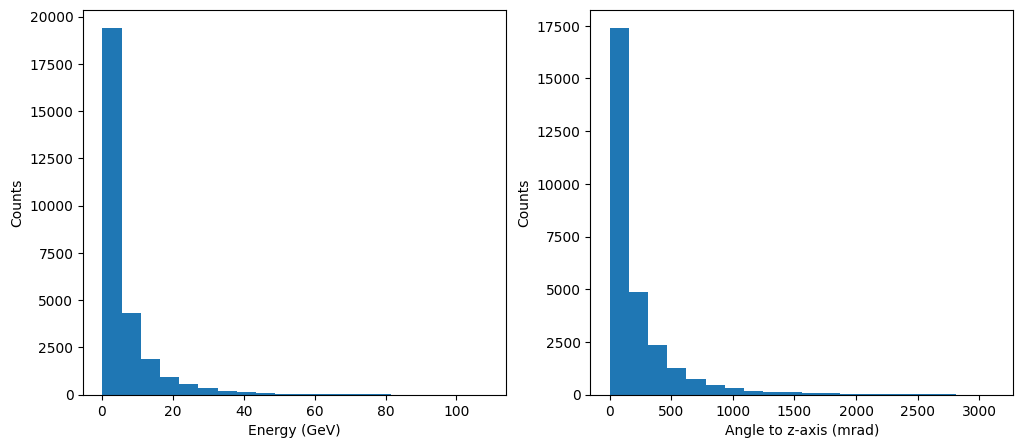

In [1138]:
import numpy as np
import matplotlib.pyplot as plt

data = df[['E', 'px', 'py', 'pz']].values
E, px, py, pz = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

# Compute angles to z-axis (θ)
theta = np.arctan2(np.sqrt(px**2 + py**2), pz)  # in radians

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(E, bins=20)
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts")

plt.subplot(122)
plt.hist(theta * 1000, bins=20)  # Convert to milliradians
plt.xlabel("Angle to z-axis (mrad)")
plt.ylabel("Counts")
plt.show()

In [1139]:
print(E.mean())
print(E.max())

6.031258107431741
108.53296975773868


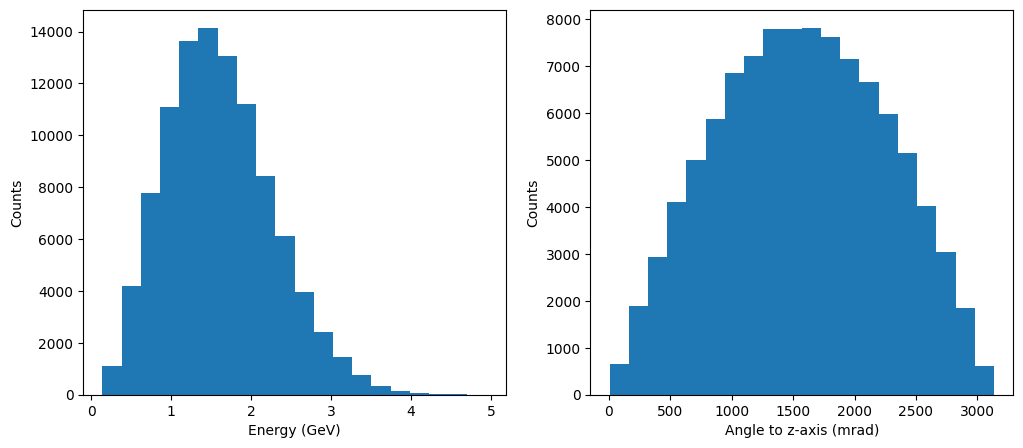

In [1140]:
import numpy as np
import matplotlib.pyplot as plt

#random data
E, px, py, pz = pi0_momenta[:, 0], pi0_momenta[:, 1], pi0_momenta[:, 2], pi0_momenta[:, 3]

# Compute angles to z-axis (θ)
theta = np.arctan2(np.sqrt(px**2 + py**2), pz)  # in radians

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.hist(E, bins=20)
plt.xlabel("Energy (GeV)")
plt.ylabel("Counts")

plt.subplot(122)
plt.hist(theta * 1000, bins=20)  # Convert to milliradians
plt.xlabel("Angle to z-axis (mrad)")
plt.ylabel("Counts")
plt.show()

In [1141]:
print(E.mean())
print(E.max())

1.6048059213999453
4.94662896182045


The following function outputs vary due to randomdomness in the generation of the data.

In [1142]:
# Constants
M_pi0 = 0.1349768  # Mass of π⁰ in GeV/c²
m_gamma = 0.0      # Mass of a photon is approximately 0
detector_size = 1.0  # Size of the detector
distance = 10.0  # Distance from the decay point to the detector

def analyze_hits(pi0_momenta):
    # Classify π⁰s by energy
    E = pi0_momenta[:, 0]
    bins = [0, 0.5, 1.0, 5.0, np.inf]
    labels = ["<0.5 GeV", "0.5-1 GeV", "1-5 GeV", ">5 GeV"]
    
    for i in range(len(bins)-1):
        mask = (E >= bins[i]) & (E < bins[i+1])
        subset = pi0_momenta[mask]
        if len(subset) > 0:
            fraction = estimate_detection_fraction_vectorized(subset, M_pi0, detector_size, distance)
            print(f"{labels[i]}: {len(subset)} π⁰s, Hit fraction = {fraction:.6f}")

analyze_hits(pi0_momenta)


<0.5 GeV: 2810 π⁰s, Hit fraction = 0.001779
0.5-1 GeV: 16405 π⁰s, Hit fraction = 0.001463
1-5 GeV: 80785 π⁰s, Hit fraction = 0.001869


In [1143]:
analyze_hits(momenta_array)


<0.5 GeV: 3027 π⁰s, Hit fraction = 0.012884
0.5-1 GeV: 3724 π⁰s, Hit fraction = 0.030344
1-5 GeV: 11885 π⁰s, Hit fraction = 0.235844
>5 GeV: 9483 π⁰s, Hit fraction = 0.780871


## My own arrays of momenta

In [1144]:
# Sample 1: High-energy π⁰s along z-axis (collimated beam)
momenta_collimated = np.array([
    [10.0, 0.0, 0.0, 9.999],  # E=10 GeV, pz ≈ 10 GeV (γ ≈ 71)
    [5.0,  0.0, 0.0, 4.999],  # E=5 GeV, pz ≈ 5 GeV (γ ≈ 36)
    [2.0,  0.0, 0.0, 1.999],  # E=2 GeV, pz ≈ 2 GeV (γ ≈ 14)
    [1.0,  0.0, 0.0, 0.999],  # E=1 GeV, pz ≈ 1 GeV (γ ≈ 7)
])

# Constants
M_pi0 = 0.1349768  # Mass of π⁰ in GeV/c²
m_gamma = 0.0      # Mass of a photon is approximately 0
detector_size = 1.0  # Size of the detector
distance = 10.0  # Distance from the decay point to the detector


# Run the simulation
fraction = estimate_detection_fraction_vectorized(momenta_collimated, M_pi0, detector_size, distance)
print(f"Fraction of decays hitting detector (collimated π⁰s): {fraction:.6f}")

Fraction of decays hitting detector (collimated π⁰s): 1.000000


In [1145]:
# Sample 2: Isotropic π⁰s (some at rest, some random directions)
momenta_isotropic = np.array([
    [M_pi0, 0.0, 0.0, 0.0],  # π⁰ at rest
    [0.2,   0.1, 0.1, 0.1],  # Low-energy, random direction
    [0.15, -0.05, 0.1, 0.1], # Low-energy, random direction
    [0.3,   0.2, -0.2, 0.1], # Higher energy, random direction
])

fraction = estimate_detection_fraction_vectorized(momenta_isotropic, M_pi0,  detector_size, distance)
print(f"Fraction of decays hitting detector (isotropic π⁰s): {fraction:.6f}")

Fraction of decays hitting detector (isotropic π⁰s): 0.000000


/tmp/ipykernel_68989/4115765569.py:20: RuntimeWarning: invalid value encountered in sqrt
  gamma = 1.0 / np.sqrt(1.0 - beta2)             # shape: (N,1)


In [1146]:
# Sample 3: One π⁰ configured to guarantee a hit
momenta_forced_hit = np.array([
    [1.0, 0.0, 0.0, 0.999],  # High-energy along z
    [0.1349768, 0.0, 0.0, 0.0],  # At rest (random hit chance)
    [0.5, 0.0, 0.0, 0.499],  # Medium-energy along z
    [0.1, 0.0, 0.0, 0.099],  # Low-energy along z (still forward-peaked)
])

# Override the first decay to force a hit
def two_body_decay_forced_hit(M, m1, m2):
    """Decay where one photon is aimed directly at the detector."""
    p_mag = M / 2  # Photon momentum in rest frame
    p1 = np.array([M/2, 0.0, 0.0, p_mag])  # Photon 1 along +z
    p2 = np.array([M/2, 0.0, 0.0, -p_mag]) # Photon 2 along -z
    return p1, p2

# Temporarily replace the decay function
original_decay = two_body_decay
two_body_decay = two_body_decay_forced_hit

fraction = estimate_detection_fraction_vectorized(momenta_forced_hit, M_pi0, detector_size, distance)
print(f"Fraction of decays hitting detector (forced hit): {fraction:.6f}")

# Restore the original function
two_body_decay = original_decay

Fraction of decays hitting detector (forced hit): 0.500000


In [1147]:
P_pi0_perfect = np.array([10.0, 0.0, 0.0, 10.0])  # β = [0,0,1]

# Override decay to emit one photon along +z
p1_rest = np.array([M_pi0/2, 0, 0, M_pi0/2])
p2_rest = np.array([M_pi0/2, 0, 0, -M_pi0/2])

p1_lab = lorentz_transform(p1_rest, [0,0,1])
p2_lab = lorentz_transform(p2_rest, [0,0,1])

assert photon_hits_detector(p1_lab)  # Must return True
#assert not photon_hits_detector(p2_lab)  # Must return False


---
# Testing the Functions

In [1148]:
#testing the functions
P = np.array([5, 3, 4, 0])  # E = 5, p = (3,4,0)
expected_mass_squared = 5**2 - (3**2 + 4**2)  # Should be 0 (massless case)
computed_mass_squared = lorentz_product(P, P)
print(computed_mass_squared, expected_mass_squared, expected_mass_squared-computed_mass_squared)
assert np.isclose(computed_mass_squared, expected_mass_squared), "Invariant mass test failed!"

0 0 0


In [1149]:
A = np.array([2, 1, 1, 0])
B = np.array([1, 1, -1, 0])  # Manually chosen so that their Lorentz product is not 0, result should be 2
print(lorentz_product(A, B))
#assert np.isclose(lorentz_product(A, B), 0), "Orthogonality test failed!"

2


In [1150]:
A = np.array([1, 1, 0, 0])
B = np.array([1, 1, 1, 1])  # Manually chosen so that their Lorentz product is not 0, result should be 2
print(lorentz_product(A, B))
assert np.isclose(lorentz_product(A, B), 0), "Orthogonality test failed!"

0


In [1151]:
# Example Usage
P1 = np.array([10, 3, 4, 0])  # Example four-momentum
P2 = np.array([8, -3, -2, 1])
velocity = np.array([0.25, 0.5, 0.1])  # Boost along x-axis

print("Lorentz product of P1 and P2:", lorentz_product(P1, P2))
print("Invariant mass of P1:", invariant_mass(P1))
print("System mass of P1 and P2:", system_mass(P1, P2))
print("Lorentz transformed P1:", lorentz_transform(P1, velocity))

Lorentz product of P1 and P2: 97
Invariant mass of P1: 8.660254037844387
System mass of P1 and P2: 17.86057109949175
Lorentz transformed P1: [ 8.80812272  0.42086519 -1.15826962 -1.03165392]


In [1152]:
P = np.array([10, 3, 4, 0])
velocity = np.array([0.6, 0, 0])  # Boost along x-direction
P_boosted = lorentz_transform(P, velocity)
print(lorentz_product(P, P), lorentz_product(P_boosted, P_boosted))
assert np.isclose(lorentz_product(P, P), lorentz_product(P_boosted, P_boosted)), "Lorentz invariance test failed!"

75 75.0


In [1153]:
# Test Cases

def test_lorentz_product():
    P = np.array([5, 3, 4, 0])  # Example four-momentum
    assert np.isclose(lorentz_product(P, P), 0), "Lorentz product test failed!"
    A = np.array([1, 1, 0, 0])
    B = np.array([1, 1, 1, 1])
    assert np.isclose(lorentz_product(A, B), 0), "Orthogonality test failed!"

def test_invariant_mass():
    P = np.array([5, 3, 4, 0])
    expected_mass = np.sqrt(5**2 - (3**2 + 4**2))
    assert np.isclose(invariant_mass(P), expected_mass), "Invariant mass test failed!"

def test_lorentz_transform():
    P = np.array([10, 3, 4, 0])
    velocity = np.array([0.6, 0, 0])
    P_boosted = lorentz_transform(P, velocity)
    assert np.isclose(lorentz_product(P, P), lorentz_product(P_boosted, P_boosted)), "Lorentz invariance test failed!"

# Run tests
test_lorentz_product()
test_invariant_mass()
test_lorentz_transform()

print("All tests passed!")

All tests passed!


---

# Two body decay of particle in rest frame

In [1154]:

M, m1, m2 = 10, 3, 4
p1, p2 = two_body_decay_rest(M, m1, m2)

print("Four-momentum of particle 1:", p1)
print("Four-momentum of particle 2:", p2)


Four-momentum of particle 1: [ 4.65        3.04643265 -0.07229193 -1.8266149 ]
Four-momentum of particle 2: [ 5.35       -3.04643265  0.07229193  1.8266149 ]


---

In [1155]:
# Compute the invariant mass of each pion (should be close to m_pi0)
df["p_mag"] = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)
df["m_pi0_calc"] = np.sqrt(df["E"]**2 - df["p_mag"]**2)

# Function to boost a 4-vector to the rest frame of the pion
def boost_to_rest_frame(E, px, py, pz):
    beta = np.array([px, py, pz]) / E  # Velocity vector
    gamma = 1 / np.sqrt(1 - np.linalg.norm(beta)**2)  # Lorentz factor
    p_prime = -gamma * beta * m_pi0 / 2
    E_prime = gamma * m_pi0 / 2
    return E_prime, p_prime[0], p_prime[1], p_prime[2]

# Generate random decay angles
theta = np.arccos(2 * np.random.rand(len(df)) - 1)  # Uniform in cos(theta)
phi = 2 * np.pi * np.random.rand(len(df))  # Uniform in phi

# Photon momenta in the rest frame
E_gamma = m_pi0 / 2  # Energy of each photon
px_rf = E_gamma * np.sin(theta) * np.cos(phi)
py_rf = E_gamma * np.sin(theta) * np.sin(phi)
pz_rf = E_gamma * np.cos(theta)

# Store photons (γ1 and γ2 are back-to-back)
df["E1_rf"], df["px1_rf"], df["py1_rf"], df["pz1_rf"] = E_gamma, px_rf, py_rf, pz_rf
df["E2_rf"], df["px2_rf"], df["py2_rf"], df["pz2_rf"] = E_gamma, -px_rf, -py_rf, -pz_rf

# Function to boost a photon back to the lab frame
def boost_to_lab_frame(row, E_rf, px_rf, py_rf, pz_rf):
    beta = np.array([row["px"], row["py"], row["pz"]]) / row["E"]
    gamma = 1 / np.sqrt(1 - np.linalg.norm(beta)**2)

    # Decompose the momentum into parallel and perpendicular components
    p_vec = np.array([px_rf, py_rf, pz_rf])
    p_parallel = np.dot(p_vec, beta) * beta / np.linalg.norm(beta)**2
    p_perpendicular = p_vec - p_parallel

    # Boost formulas
    E_lab = gamma * (E_rf + np.dot(beta, p_vec))
    p_lab = p_perpendicular + gamma * (p_parallel + beta * E_rf)

    return pd.Series([E_lab, p_lab[0], p_lab[1], p_lab[2]])

# Apply boost transformation to both photons
df[["E1", "px1", "py1", "pz1"]] = df.apply(lambda row: boost_to_lab_frame(row, row["E1_rf"], row["px1_rf"], row["py1_rf"], row["pz1_rf"]), axis=1)
df[["E2", "px2", "py2", "pz2"]] = df.apply(lambda row: boost_to_lab_frame(row, row["E2_rf"], row["px2_rf"], row["py2_rf"], row["pz2_rf"]), axis=1)

# Drop rest-frame columns if not needed
df.drop(columns=["E1_rf", "px1_rf", "py1_rf", "pz1_rf", "E2_rf", "px2_rf", "py2_rf", "pz2_rf"], inplace=True)

# Inspect results
print(df.head())

          E        px        py        pz     p_mag  m_pi0_calc        E1  \
0  9.290869 -0.201131 -0.665001  9.263873  9.289888     0.13498  2.295535   
1  0.396785 -0.209107  0.078034  0.299004  0.373120     0.13498  0.355506   
2  4.349881  0.750735 -0.150422  4.279838  4.347786     0.13498  0.594278   
3  6.213590 -0.211418 -0.182143  6.205853  6.212124     0.13498  3.422464   
4  2.706387 -0.078871 -0.002744  2.701867  2.703019     0.13498  1.768791   

        px1       py1       pz1        E2       px2       py2       pz2  
0  0.003760 -0.141359  2.291176  6.995099 -0.204887 -0.523625  6.972464  
1 -0.202805  0.107963  0.271290  0.041269 -0.006297 -0.029931  0.027706  
2  0.127466  0.018286  0.580159  3.755493  0.623250 -0.168704  3.699571  
3 -0.053548 -0.077041  3.421177  2.790970 -0.157865 -0.105097  2.784520  
4  0.006180  0.026224  1.768585  0.937529 -0.085049 -0.028968  0.933213  


# Validating Conservation of Energy and Momentum
$$
E_{\pi^0} = E_1 + E_2 \\
\vec{p}_{\pi^0} = \vec{p}_1 + \vec{p}_2
$$
To see how well these hold, compute the energy and momentum differences and plot their distributions:
$$
E_{\pi^0} - (E_1 + E_2) \\
|\vec{p}_{\pi^0} - (\vec{p}_1 + \vec{p}_2)|
$$

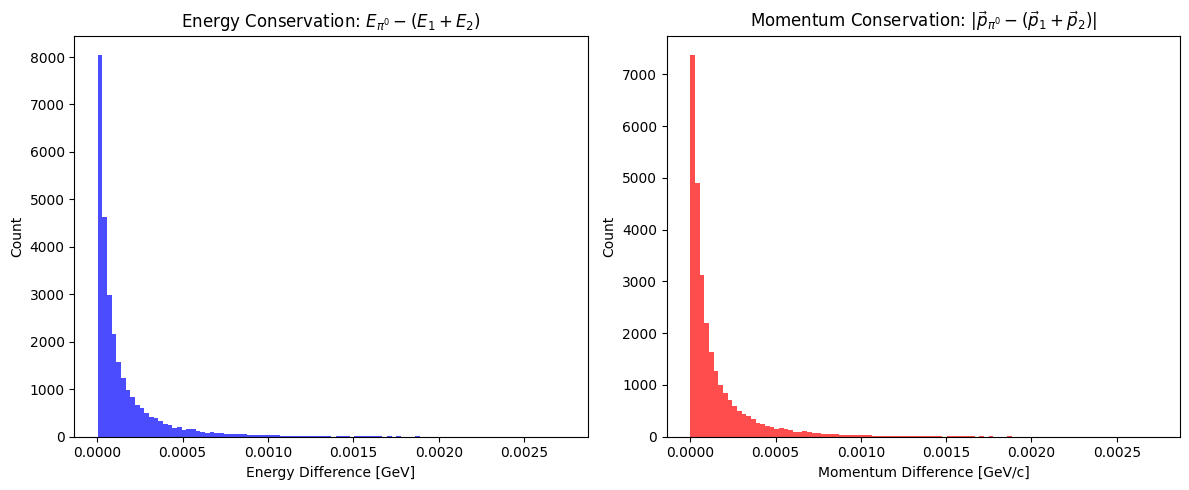

In [1156]:

# Conservation checks
df["energy_diff"] = df["E"] - (df["E1"] + df["E2"])
df["momentum_diff"] = np.sqrt(
    (df["px"] - (df["px1"] + df["px2"]))**2 +
    (df["py"] - (df["py1"] + df["py2"]))**2 +
    (df["pz"] - (df["pz1"] + df["pz2"]))**2
)

# Plot energy and momentum conservation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df["energy_diff"], bins=100, color="blue", alpha=0.7)
axes[0].set_title("Energy Conservation: $E_{π^0} - (E_1 + E_2)$")
axes[0].set_xlabel("Energy Difference [GeV]")
axes[0].set_ylabel("Count")

axes[1].hist(df["momentum_diff"], bins=100, color="red", alpha=0.7)
axes[1].set_title("Momentum Conservation: $|\\vec{p}_{π^0} - (\\vec{p}_1 + \\vec{p}_2)|$")
axes[1].set_xlabel("Momentum Difference [GeV/c]")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [1157]:

def two_body_decay_test(m, m1, m2, pion_momentum, c=1):
    """
    Computes the momentum and energies of the decay products in a two-body decay.
    
    Parameters:
        m  (float): Mass of the parent particle (in natural units if c=1).
        m1 (float): Mass of the first daughter particle.
        m2 (float): Mass of the second daughter particle.
        pion_momentum (float): Initial momentum of the pion in the lab frame.
        c  (float): Speed of light (default is 1 for natural units).
    
    Returns:
        p_lab_1 (float): Momentum of the first daughter particle in the lab frame.
        p_lab_2 (float): Momentum of the second daughter particle in the lab frame.
        E_lab_1 (float): Energy of the first daughter particle in the lab frame.
        E_lab_2 (float): Energy of the second daughter particle in the lab frame.
    """
    if m < (m1 + m2):
        raise ValueError("Decay is kinematically forbidden (parent mass too small).")
    
    # Compute momentum in the pion rest frame
    p_rest = np.sqrt((m**2 - (m1 + m2)**2) * (m**2 - (m1 - m2)**2)) / (2 * m) * c
    
    # Compute energies in the rest frame
    E1_rest = np.sqrt(p_rest**2 * c**2 + m1**2 * c**4)
    E2_rest = np.sqrt(p_rest**2 * c**2 + m2**2 * c**4)
    
    # Compute Lorentz factor for the pion in the lab frame
    E_pion = np.sqrt(pion_momentum**2 * c**2 + m**2 * c**4)
    gamma = E_pion / (m * c**2)
    beta = pion_momentum / E_pion
    
    # Apply Lorentz transformation to the decay products
    E_lab_1 = gamma * (E1_rest + beta * p_rest * c)
    E_lab_2 = gamma * (E2_rest - beta * p_rest * c)
    
    p_lab_1 = np.sqrt(E_lab_1**2 / c**2 - m1**2 * c**2)
    p_lab_2 = np.sqrt(E_lab_2**2 / c**2 - m2**2 * c**2)
    
    return p_lab_1, p_lab_2, E_lab_1, E_lab_2

# Example usage: Neutral pion decay (pi0 -> gamma gamma) in motion
m_pi0 = 134.98  # MeV/c^2
m_gamma = 0      # Photon mass in MeV/c^2
pion_momentum = 500  # MeV/c (example lab-frame momentum)

p_lab_1, p_lab_2, E_lab_1, E_lab_2 = two_body_decay_test(m_pi0, m_gamma, m_gamma, pion_momentum)

print(f"Photon 1 momentum in lab frame: {p_lab_1:.2f} MeV/c")
print(f"Photon 2 momentum in lab frame: {p_lab_2:.2f} MeV/c")
print(f"Photon 1 energy in lab frame: {E_lab_1:.2f} MeV")
print(f"Photon 2 energy in lab frame: {E_lab_2:.2f} MeV")

Photon 1 momentum in lab frame: 508.95 MeV/c
Photon 2 momentum in lab frame: 8.95 MeV/c
Photon 1 energy in lab frame: 508.95 MeV
Photon 2 energy in lab frame: 8.95 MeV


In [1158]:
def two_body_decay_test1(m, m1, m2, c=1):
    """
    Computes the momentum and energies of the decay products in a two-body decay.
    
    Parameters:
        m  (float): Mass of the parent particle (in natural units if c=1).
        m1 (float): Mass of the first daughter particle.
        m2 (float): Mass of the second daughter particle.
        c  (float): Speed of light (default is 1 for natural units).
    
    Returns:
        p  (float): Magnitude of momentum of decay products.
        E1 (float): Energy of the first daughter particle.
        E2 (float): Energy of the second daughter particle.
    """
    if m < (m1 + m2):
        raise ValueError("Decay is kinematically forbidden (parent mass too small).")
    
    # Compute momentum using relativistic kinematics formula
    p = np.sqrt((m**2 - (m1 + m2)**2) * (m**2 - (m1 - m2)**2)) / (2 * m) * c
    
    # Compute energies using energy-momentum relation
    E1 = np.sqrt(p**2 * c**2 + m1**2 * c**4)
    E2 = np.sqrt(p**2 * c**2 + m2**2 * c**4)
    
    return p, E1, E2

# Example usage: Neutral pion decay (pi0 -> gamma gamma)
m_pi0 = 134.98  # MeV/c^2
m_gamma = 0      # Photon mass in MeV/c^2

p, E1, E2 = two_body_decay_test1(m_pi0, m_gamma, m_gamma)

print(f"Photon momentum: {p:.2f} MeV/c")
print(f"Photon energies: E1 = {E1:.2f} MeV, E2 = {E2:.2f} MeV")


Photon momentum: 67.49 MeV/c
Photon energies: E1 = 67.49 MeV, E2 = 67.49 MeV


In [1159]:
def lorentz_product(A, B):
    """Computes the Lorentz product of two four-vectors."""
    return A[0] * B[0] - np.dot(A[1:], B[1:])

def invariant_mass(P):
    """Computes the invariant mass of a four-momentum vector P."""
    mass_squared = lorentz_product(P, P)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0.0

def system_mass(P1, P2):
    """Computes the invariant mass of a system of two particles."""
    P_total = P1 + P2
    mass_squared = lorentz_product(P_total, P_total)
    return np.sqrt(mass_squared) if mass_squared > 0 else 0.0

def lorentz_transform(P, v):
    """Applies a Lorentz boost to a four-vector P in the direction of velocity v."""
    v = np.asarray(v)
    v_mag = np.linalg.norm(v)
    
    # Ensure velocity is a valid subluminal value
    if v_mag >= 1.0:
        v = v / (v_mag + 1e-10)
        v_mag = np.linalg.norm(v)
    
    beta = v_mag
    gamma = 1 / np.sqrt(1 - beta ** 2)
    n = v / v_mag  # Normalize direction
    
    # Lorentz transformation matrix
    Lambda = np.array([
        [gamma, -gamma * beta * n[0], -gamma * beta * n[1], -gamma * beta * n[2]],
        [-gamma * beta * n[0], 1 + (gamma - 1) * n[0]**2, (gamma - 1) * n[0] * n[1], (gamma - 1) * n[0] * n[2]],
        [-gamma * beta * n[1], (gamma - 1) * n[1] * n[0], 1 + (gamma - 1) * n[1]**2, (gamma - 1) * n[1] * n[2]],
        [-gamma * beta * n[2], (gamma - 1) * n[2] * n[0], (gamma - 1) * n[2] * n[1], 1 + (gamma - 1) * n[2]**2]
    ])
    
    return np.dot(Lambda, P)

def two_body_decay(M, m1, m2):
    """Generates two random four-momenta for a two-body decay in the rest frame of the decaying particle."""
    E1 = (M**2 + m1**2 - m2**2) / (2 * M)
    E2 = (M**2 + m2**2 - m1**2) / (2 * M)
    p_mag = np.sqrt(max(E1**2 - m1**2, 0))  # Ensure non-negative
    
    # Generate a random isotropic direction
    cos_theta = 2 * np.random.rand() - 1  # Uniform sampling in [-1, 1]
    sin_theta = np.sqrt(1 - cos_theta**2)
    phi = 2 * np.pi * np.random.rand()  # Uniform in [0, 2π)
    
    p1 = np.array([
        E1,
        p_mag * sin_theta * np.cos(phi),
        p_mag * sin_theta * np.sin(phi),
        p_mag * cos_theta
    ])
    
    p2 = np.array([E2, -p1[1], -p1[2], -p1[3]])  # Opposite direction
    
    return p1, p2

def photon_hits_detector(p_photon):
    """Check if a photon hits a detector at z=10m with a 1m x 1m face centered at (0,0,10)."""
    if p_photon[3] <= 0:
        return False  # Photon moving away from detector
    
    scale = 10 / p_photon[3]  # Intersection at z = 10m
    x_hit, y_hit = p_photon[1] * scale, p_photon[2] * scale
    
    return -0.5 <= x_hit <= 0.5 and -0.5 <= y_hit <= 0.5

def estimate_detection_fraction(pi0_momenta, M, m1, m2):
    """Estimate the fraction of decays where at least one photon hits the detector."""
    count_detected = 0
    total_decays = len(pi0_momenta)
    
    for P_pi0 in pi0_momenta:
        p1, p2 = two_body_decay(M, m1, m2)  # Decay in rest frame
        p1_lab = lorentz_transform(p1, P_pi0[1:] / P_pi0[0])
        p2_lab = lorentz_transform(p2, P_pi0[1:] / P_pi0[0])
        
        if photon_hits_detector(p1_lab) or photon_hits_detector(p2_lab):
            count_detected += 1
    
    return count_detected / total_decays

In [1160]:
def is_photon_hit(p_photon, detector_size=1.0, distance=10.0):
    """Check if a photon hits the detector, regardless of direction."""
    px, py, pz = p_photon[1:]
    p_mag = np.sqrt(px**2 + py**2 + pz**2)
    
    if np.isclose(pz, 0):
        return False  # Photon travels parallel to detector plane
    
    t = distance / pz  # Parametric distance to intersection
    x_hit = px * t
    y_hit = py * t
    
    return (abs(x_hit) <= detector_size/2) and (abs(y_hit) <= detector_size/2)

def vectorized_lorentz_transform(p, v):
    """
    Boost a batch of 4-vectors p (shape: [N, 4]) 
    with velocities v (shape: [N, 3]).
    p has columns [E, p_x, p_y, p_z].
    """
    # Calculate squared speed (beta^2) for each event
    beta2 = np.sum(v**2, axis=1, keepdims=True)  # shape: (N,1)
    # Calculate gamma factor for each event
    gamma = 1.0 / np.sqrt(1.0 - beta2)  # shape: (N,1)
    
    # Compute dot product between spatial parts of p and v for each event (bp)
    bp = np.sum(p[:, 1:] * v, axis=1, keepdims=True)  # shape: (N,1)
    
    # Avoid division by zero for cases where beta2==0 (i.e. no boost)
    with np.errstate(divide='ignore', invalid='ignore'):
        gamma2 = np.where(beta2 > 0, (gamma - 1.0) / beta2, 0.0)  # shape: (N,1)
    
    # Transform spatial components.
    # p[:, 1:] has shape (N,3), so do the other terms accordingly.
    spatial = p[:, 1:] + gamma2 * bp * v + gamma * p[:, :1] * v  # shape: (N,3)
    
    # Transform energy.
    energy = gamma * (p[:, :1] + bp)  # shape: (N,1)
    
    # Concatenate energy and spatial components; both have N rows.
    return np.hstack([energy, spatial])  # resulting shape: (N,4)

In [1161]:
def estimate_detection_fraction_vectorized(pi0_momenta, M, m1, m2, detector_size=1.0, distance=10.0):
    n_decays = len(pi0_momenta)
    
    # Generate isotropic decays in rest frame
    cos_theta = 2 * np.random.rand(n_decays) - 1
    theta = np.arccos(cos_theta)
    phi = 2 * np.pi * np.random.rand(n_decays)
    p_mag = M / 2  # Photon momentum in rest frame
    
    p1_rest = np.column_stack([
        M/2,
        p_mag * np.sin(theta) * np.cos(phi),
        p_mag * np.sin(theta) * np.sin(phi),
        p_mag * cos_theta
    ])
    p2_rest = p1_rest * np.array([1, -1, -1, -1])  # Opposite momentum
    
    # Boost to lab frame
    v = pi0_momenta[:, 1:] / pi0_momenta[:, 0:1]  # v = p/E
    p1_lab = vectorized_lorentz_transform(p1_rest, v)
    p2_lab = vectorized_lorentz_transform(p2_rest, v)
    
    # Check hits for both photons
    hits = np.zeros(n_decays, dtype=bool)
    for p in [p1_lab, p2_lab]:
        pz_nonzero = ~np.isclose(p[:, 3], 0)
        t = np.where(pz_nonzero, distance / p[:, 3], np.inf)
        x_hit = p[:, 1] * t
        y_hit = p[:, 2] * t
        hits |= pz_nonzero & (np.abs(x_hit) <= detector_size/2) & (np.abs(y_hit) <= detector_size/2)
    
    return np.mean(hits)

In [1162]:
def vectorized_lorentz_transform(p, v):
    """
    Perform a Lorentz boost on a batch of 4-vectors.
    
    Parameters
    ----------
    p : numpy.ndarray
        Array of 4-vectors in the rest frame, shape (N, 4), with columns [E, px, py, pz].
    v : numpy.ndarray
        Array of boost velocities, shape (N, 3). (Assuming units where c=1.)
    
    Returns
    -------
    numpy.ndarray
        Boosted 4-vectors in the lab frame, shape (N, 4).
    """
    # Compute beta^2 for each event (v²)
    beta2 = np.sum(v**2, axis=1, keepdims=True)  # shape: (N,1)
    # Calculate gamma factor for each event
    gamma = 1.0 / np.sqrt(1.0 - beta2)             # shape: (N,1)
    # Dot product between the spatial momentum and the boost velocity
    bp = np.sum(p[:, 1:] * v, axis=1, keepdims=True)  # shape: (N,1)
    
    # Calculate the factor (gamma - 1)/beta2 safely. Set to 0 when beta2 is nearly zero.
    with np.errstate(divide='ignore', invalid='ignore'):
        gamma2 = np.where(beta2 > 1e-12, (gamma - 1.0) / beta2, 0.0)  # shape: (N,1)
    
    # Boost the spatial components:
    # p[:, 1:] is (N,3) and v is (N,3); the operations are elementwise.
    spatial = p[:, 1:] + gamma2 * bp * v + gamma * p[:, :1] * v  # shape: (N,3)
    # Boost the energy component:
    energy = gamma * (p[:, :1] + bp)  # shape: (N,1)
    
    # Concatenate boosted energy and spatial parts along axis 1.
    boosted = np.hstack([energy, spatial])
    return boosted

def estimate_detection_fraction_vectorized(pi0_momenta, M, detector_size=1.0, distance=10.0):
    """
    Estimate the fraction of π⁰ decays for which at least one photon hits the detector.
    
    The detector is assumed to be a square centered at (x, y) = (0, 0) in a plane 
    located at z = distance. The size of the detector is detector_size (length of a side).
    
    Parameters
    ----------
    pi0_momenta : numpy.ndarray
        Lab frame 4-momenta of the π⁰ particles (shape: [N,4] with columns [E, px, py, pz]).
    M : float
        Mass of the π⁰ particle (in GeV/c²).
    detector_size : float, optional
        Size of the detector (side length), by default 1.0.
    distance : float, optional
        z-distance to the detector plane, by default 10.0.
    
    Returns
    -------
    float
        The estimated geometric efficiency (fraction of decays detected).
    """
    n_decays = len(pi0_momenta)
    
    # Generate random angles for isotropic decays in the pion rest frame.
    cos_theta = 2 * np.random.rand(n_decays) - 1
    theta = np.arccos(cos_theta)
    phi = 2 * np.pi * np.random.rand(n_decays)
    
    # In the rest frame of the π⁰, energy = |p| for a photon. Each photon gets half the mass.
    p_mag = M / 2.0

    # Photon 1 in the rest frame: 4-vector [E, px, py, pz]
    p1_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        p_mag * np.sin(theta) * np.cos(phi),
        p_mag * np.sin(theta) * np.sin(phi),
        p_mag * cos_theta
    ])
    
    # Photon 2 has exactly the opposite momentum.
    p2_rest = np.column_stack([
        np.full(n_decays, p_mag),                # Energy
        -p_mag * np.sin(theta) * np.cos(phi),
        -p_mag * np.sin(theta) * np.sin(phi),
        -p_mag * cos_theta
    ])
    
    # Compute the boost velocity of the π⁰: v = p/E
    # pi0_momenta has columns [E, px, py, pz]
    v = pi0_momenta[:, 1:] / pi0_momenta[:, :1]  # shape: (N,3)
    
    # Boost both photons to the lab frame.
    p1_lab = vectorized_lorentz_transform(p1_rest, v)
    p2_lab = vectorized_lorentz_transform(p2_rest, v)
    
    def check_hits(p):
        """
        Check if the boosted photon (p) hits the detector.
        
        p is expected to be a numpy array of shape (N,4) for lab-frame 4-vectors.
        """
        # We are interested in the photon's z-component; if it is nearly zero or negative (moving backward), it won't hit.
        pz = p[:, 3]
        nonzero = np.abs(pz) > 1e-8
        # For photons moving toward the detector (i.e. pz > 0), compute the parametric distance t such that z = distance.
        # For non-moving or backward-moving photons, set t = infinity.
        t = np.where((pz > 0) & nonzero, distance / pz, np.inf)
        # The photon hits at positions (x_hit, y_hit)
        x_hit = p[:, 1] * t
        y_hit = p[:, 2] * t
        # Check if (x_hit, y_hit) fall within half the detector size.
        hit = (np.abs(x_hit) <= detector_size / 2.0) & (np.abs(y_hit) <= detector_size / 2.0)
        # Only count if the photon is moving forward.
        hit = hit & (pz > 0)
        return hit
    
    hits1 = check_hits(p1_lab)
    hits2 = check_hits(p2_lab)
    
    # An event is detected if at least one of the two photons hits the detector.
    detected = hits1 | hits2
    fraction_detected = np.mean(detected)
    return fraction_detected

if __name__ == '__main__':
    # Define the π⁰ mass (in GeV/c²)
    M_pi0 = 0.1349768
    n_events = 100000  # Number of decays to simulate
    
    # Generate random lab frame π⁰ momenta.
    # We'll sample the spatial momentum components from a normal distribution.
    lab_momenta_spatial = np.random.normal(0, 1, (n_events, 3))
    # Compute the energy using E = sqrt(p^2 + m^2)
    energies = np.sqrt(np.sum(lab_momenta_spatial**2, axis=1) + M_pi0**2)
    # Construct the π⁰ momenta array with columns [E, px, py, pz]
    pi0_momenta = np.column_stack([energies, lab_momenta_spatial])
    
    # Estimate the geometric efficiency:
    fraction = estimate_detection_fraction_vectorized(pi0_momenta, M_pi0,
                                                      detector_size=1.0,
                                                      distance=10.0)
    print(f"Geometric efficiency: {fraction:.6f}")

Geometric efficiency: 0.001650


In [1163]:
# reload data
data_path = 'pi0s_from_120_GeV_pp.dat'
df = pd.read_csv(data_path, delim_whitespace=True, header=None)
df.columns = ['E', 'px', 'py', 'pz']
momenta_array = df[['E', 'px', 'py', 'pz']].to_numpy() 


/tmp/ipykernel_68989/2051923735.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(data_path, delim_whitespace=True, header=None)


In [1164]:
# Set up the mass constants
M_pi0 = 0.1349768  # Mass of π⁰ in GeV/c²
m_gamma = 0.0      # Mass of a photon (approximated as 0)

# Simulated momenta array for π⁰ particles; replace with your actual data
# For example, let's assume a few dummy momenta for demonstration purposes
# momenta_array = np.array([[E, px, py, pz], ...])


# Calling the function to estimate the detection fraction
fraction = estimate_detection_fraction(momenta_array, M_pi0, m_gamma, m_gamma)
print(f"Fraction of decays hitting detector: {fraction:.12f}")

# Output the fraction
# This will give you an estimate of the proportion of π⁰ decays where at least one photon hits the detector

Fraction of decays hitting detector: 0.000035563142


The outputs are the same results.